In [1]:
!pip install -q mgz pandas matplotlib numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#from google.colab import files
#
#uploaded = files.upload()

Saving AgeIIDE_Replay_396581946.aoe2record to AgeIIDE_Replay_396581946.aoe2record


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00
🔄 Selecciona un archivo .aoe2record para analizar…


Saving AgeIIDE_Replay_396581946.aoe2record to AgeIIDE_Replay_396581946 (1).aoe2record
Mapa: Arabia — Duración: 81.6 min

👷‍ Aldeanos creados
  santiagoap: 0
  The nicest husband: 0

⏳ Tiempo TC inactivo (s)
  santiagoap: 0.0
  The nicest husband: 0.0


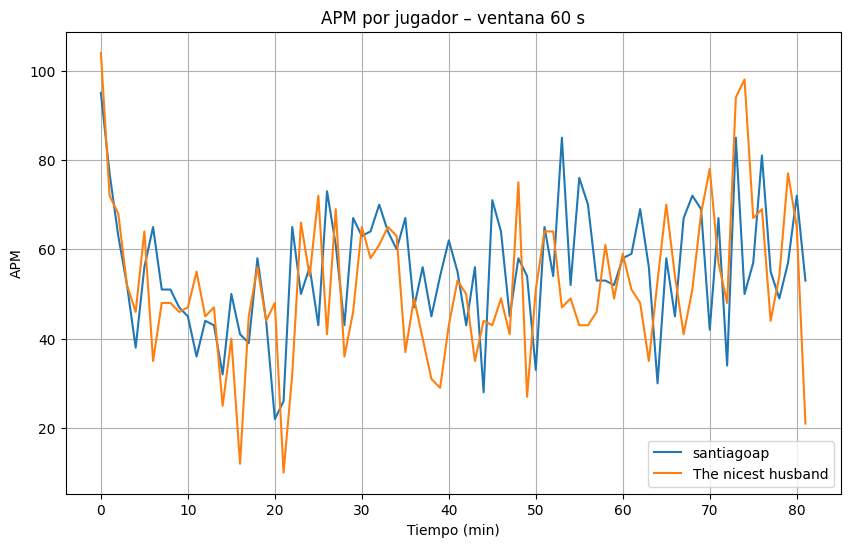

In [3]:
# AoE2 Replay Analyzer – Google Colab 🔬🎮
# ==========================================
# Notebook listo para ejecutarse en Google Colab sin dependencias
# fuera de PyPI.  Se han eliminado las marcas `# %% [markdown]` que
# causaban celdas molestas; sólo permanecen separadores `# %%` de
# código.
# -----------------------------------------------------------------------------

# %% Instalar dependencias
# Ejecuta una vez; `mgz` ≥1.8 se compila rápido (puro Python + construct)
!pip -q install --upgrade pip wheel
!pip -q install mgz pandas numpy matplotlib tqdm

# %% Imports y configuración general
import os, json, math
from datetime import timedelta
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# mgz – librería principal
from mgz.model import parse_match, serialize  # devuelve objeto Match

# Constantes
VILLAGER_STRINGS = {"Villager", "Villagers"}  # robusto a localización EN/ES
WINDOW_SEC = 60  # ventana para APM

# %% Funciones auxiliares

def load_match(replay_path: str):
    """Abre el `.aoe2record` y devuelve el objeto `Match`."""
    with open(replay_path, "rb") as fh:
        return parse_match(fh)


def villager_counts(match):
    """Número de aldeanos creados por jugador."""
    counts = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name == "TRAIN":
            unit = act.payload.get("unit") or {}
            # Según versión, puede venir como dict o dataclass
            name = getattr(unit, "name", None) or unit.get("name")
            if name in VILLAGER_STRINGS or name.lower().startswith("villager"):
                if act.player:
                    counts[act.player.number] += 1
    return counts


def tc_idle_time(match):
    """Tiempo total (seg.) que cada jugador tiene *todos* sus TC inactivos.
    Aproximación: huecos > 30 s entre entrenamientos consecutivos de aldeanos."""
    idle = {p.number: 0.0 for p in match.players}
    last_train = {p.number: None for p in match.players}
    for act in match.actions:
        if act.type.name != "TRAIN":
            continue
        unit = act.payload.get("unit") or {}
        name = getattr(unit, "name", None) or unit.get("name")
        if not (name in VILLAGER_STRINGS or name.lower().startswith("villager")):
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        t = act.timestamp.total_seconds()
        if last_train[pid] is not None:
            gap = t - last_train[pid]
            # Aldeano tarda ~25 s; consideramos inactivo si gap > 27 s
            if gap > 27.0:
                idle[pid] += gap - 27.0
        last_train[pid] = t
    return idle


def apm_timeseries(match, window_sec: int = WINDOW_SEC):
    """DataFrame de APM por jugador (ventana deslizante)."""
    rows = []
    for act in match.actions:
        if not act.player:
            continue
        rows.append((act.timestamp.total_seconds(), act.player.number))
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows, columns=["t", "player"])
    max_t = df["t"].max()
    bins = np.arange(0, max_t + window_sec, window_sec)
    apm = {}
    for pid in df["player"].unique():
        counts, _ = np.histogram(df.loc[df["player"] == pid, "t"], bins=bins)
        apm[pid] = counts * 60 / window_sec
    ts = pd.DataFrame(apm, index=bins[:-1])
    ts.index.name = "time_sec"
    return ts


def plot_apm(ts, match):
    if ts.empty:
        print("Sin acciones suficientes para APM.")
        return
    plt.figure(figsize=(10, 6))
    for pid in ts.columns:
        name = next(p.name for p in match.players if p.number == pid)
        plt.plot(ts.index / 60, ts[pid], label=name)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("APM")
    plt.title("APM por jugador – ventana {} s".format(WINDOW_SEC))
    plt.grid(True)
    plt.legend()
    plt.show()

# %% Subir replay (widget Colab)
from google.colab import files  # type: ignore
print("🔄 Selecciona un archivo .aoe2record para analizar…")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No se subió ningún archivo")
REPLAY_PATH = next(iter(uploaded))

# %% Procesar y mostrar métricas
match = load_match(REPLAY_PATH)
print(f"Mapa: {match.map.name} — Duración: {match.duration.total_seconds()/60:.1f} min\n")

villagers = villager_counts(match)
idles = tc_idle_time(match)
aps = apm_timeseries(match)

print("👷‍ Aldeanos creados")
for p in match.players:
    print(f"  {p.name}: {villagers[p.number]}")

print("\n⏳ Tiempo TC inactivo (s)")
for p in match.players:
    print(f"  {p.name}: {idles[p.number]:.1f}")

plot_apm(aps, match)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'mgz' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'mgz'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'construct' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.t

Saving AgeIIDE_Replay_398140917.aoe2record to AgeIIDE_Replay_398140917.aoe2record
Mapa: Arabia — Duración: 31.5 min

👷‍ Aldeanos creados
  jeap95: 0
  Bombita: 0

⏳ Tiempo TC inactivo (s)
  jeap95: 0.0
  Bombita: 0.0


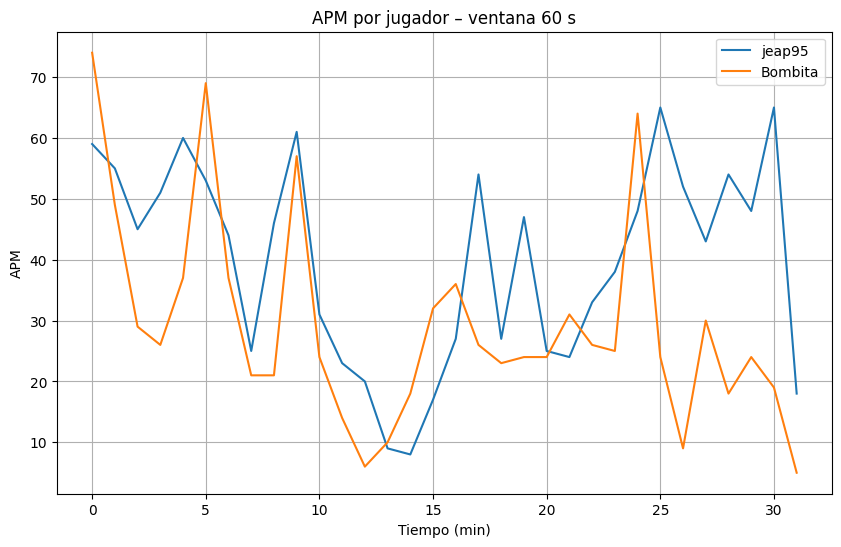

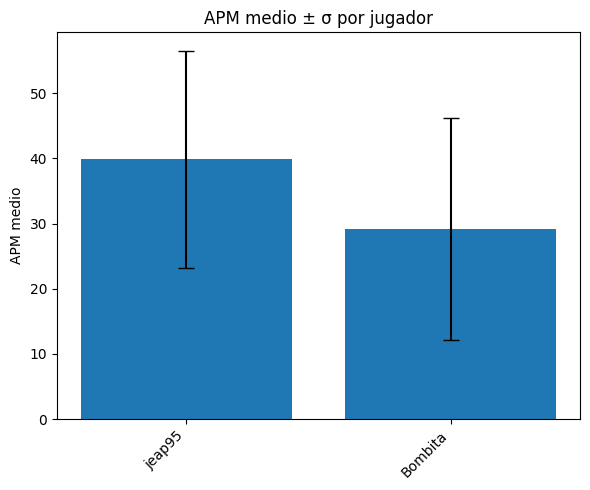

In [ ]:
# AoE2 Replay Analyzer – Google Colab 🔬🎮
# ==========================================
# Notebook listo para ejecutarse en Google Colab **sólo con paquetes PyPI**.
# Se han suprimido las celdas markdown; únicamente hay separadores `# %%`.
# -----------------------------------------------------------------------------

# %% Instalar dependencias
# Ejecuta una vez; `mgz` >= 1.8 está en PyPI (100 % Python, sin compilación).
!pip -q install --upgrade pip wheel
!pip -q install mgz pandas numpy matplotlib tqdm

# %% Imports y configuración general
import os, json, math, re
from datetime import timedelta
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# mgz – librería principal (versión pura‑Python)
from mgz.model import parse_match  # devuelve objeto Match

# Constantes y parámetros
WINDOW_SEC = 60  # ventana, en segundos, para la serie temporal de APM
# Expresiones regulares para identificar aldeanos sin depender del idioma
_VILLAGER_RE = re.compile(r"villager|aldean", re.IGNORECASE)

# %% Funciones auxiliares

def load_match(replay_path: str):
    """Abre el `.aoe2record` y devuelve el objeto `Match`."""
    with open(replay_path, "rb") as fh:
        return parse_match(fh)


def is_villager(unit_name: str | None) -> bool:
    """Heurística robusta para reconocer aldeanos por nombre."""
    if not unit_name:
        return False
    return bool(_VILLAGER_RE.search(unit_name))


def villager_counts(match):
    """Número de aldeanos creados por jugador.
    Se basa en comandos TRAIN cuyo `unit` o `unit_name` contiene *villager*/ *aldeano*.
    """
    counts = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name != "TRAIN":
            continue
        # Distintas versiones exponen el nombre de unidad en lugares diferentes
        unit_obj = act.payload.get("unit") or {}
        name = (
            getattr(unit_obj, "name", None)
            or unit_obj.get("name")
            or act.payload.get("unit_name")
        )
        if is_villager(name):
            pid = act.player.number if act.player else None
            if pid is not None:
                counts[pid] += 1
    return counts


def tc_idle_time(match, base_prod_time: float = 25.0, gap_threshold: float = 27.0):
    """Tiempo total (s) que **todos** los TC están inactivos para cada jugador.

    Aproximación: intervalo entre entrenamientos de aldeano `gap > gap_threshold`.
    """
    idle = {p.number: 0.0 for p in match.players}
    last_train = {p.number: None for p in match.players}
    for act in match.actions:
        if act.type.name != "TRAIN":
            continue
        unit_obj = act.payload.get("unit") or {}
        name = (
            getattr(unit_obj, "name", None)
            or unit_obj.get("name")
            or act.payload.get("unit_name")
        )
        if not is_villager(name):
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        t = act.timestamp.total_seconds()
        if last_train[pid] is not None:
            gap = t - last_train[pid]
            if gap > gap_threshold:
                idle[pid] += gap - base_prod_time  # tiempo real *ocioso*
        last_train[pid] = t
    return idle


def apm_timeseries(match, window_sec: int = WINDOW_SEC):
    """`DataFrame` de APM por jugador usando ventana deslizante de `window_sec`."""
    rows = [(act.timestamp.total_seconds(), act.player.number)
            for act in match.actions if act.player]
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows, columns=["t", "player"])
    max_t = df["t"].max()
    bins = np.arange(0, max_t + window_sec, window_sec)
    apm = {}
    for pid in df["player"].unique():
        counts, _ = np.histogram(df.loc[df["player"] == pid, "t"], bins=bins)
        apm[pid] = counts * 60 / window_sec
    ts = pd.DataFrame(apm, index=bins[:-1])
    ts.index.name = "time_sec"
    return ts


def plot_apm(ts, match):
    """Curva de APM en el tiempo para cada jugador."""
    if ts.empty:
        print("Sin acciones suficientes para APM.")
        return
    plt.figure(figsize=(10, 6))
    for pid in ts.columns:
        name = next(p.name for p in match.players if p.number == pid)
        plt.plot(ts.index / 60, ts[pid], label=name)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("APM")
    plt.title(f"APM por jugador – ventana {WINDOW_SEC} s")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_apm_bar(ts, match):
    """Gráfica de barras del APM medio ± desviación estándar por jugador."""
    if ts.empty:
        print("Sin datos para generar barplot de APM.")
        return
    means = ts.mean()
    stds = ts.std()
    names = [next(p.name for p in match.players if p.number == pid) for pid in means.index]
    x = np.arange(len(names))
    plt.figure(figsize=(6, 5))
    plt.bar(x, means.values, yerr=stds.values, capsize=6)
    plt.xticks(x, names, rotation=45, ha="right")
    plt.ylabel("APM medio")
    plt.title("APM medio ± σ por jugador")
    plt.tight_layout()
    plt.show()

# %% Subir replay (widget Colab)
from google.colab import files  # type: ignore
print("🔄 Selecciona un archivo .aoe2record para analizar…")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No se subió ningún archivo")
REPLAY_PATH = next(iter(uploaded))

# %% Procesar y mostrar métricas
match = load_match(REPLAY_PATH)
print(f"Mapa: {match.map.name} — Duración: {match.duration.total_seconds()/60:.1f} min\n")

# Cálculo de métricas
villagers = villager_counts(match)
idles = tc_idle_time(match)
aps = apm_timeseries(match)

# Resultados en consola
print("👷‍ Aldeanos creados")
for p in match.players:
    print(f"  {p.name}: {villagers[p.number]}")

print("\n⏳ Tiempo TC inactivo (s)")
for p in match.players:
    print(f"  {p.name}: {idles[p.number]:.1f}")

# Visualizaciones
plot_apm(aps, match)
plot_apm_bar(aps, match)


In [ ]:
# %% INSTALAR DEPENDENCIAS (solo si aún no las tienes)
# En Colab deberías ejecutar esto una vez:
!pip -q install --upgrade pip wheel
!pip -q install mgz pandas numpy matplotlib tqdm

🔄 Selecciona un archivo .aoe2record para analizar…


Saving AgeIIDE_Replay_398140917.aoe2record to AgeIIDE_Replay_398140917 (1).aoe2record
Mapa: Arabia — Duración: 31.5 min

▶︎ Calculando APM…


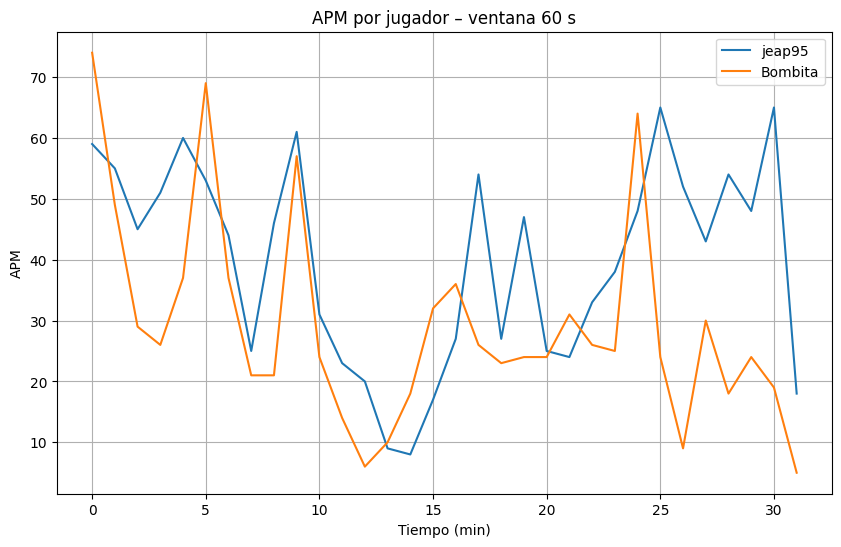

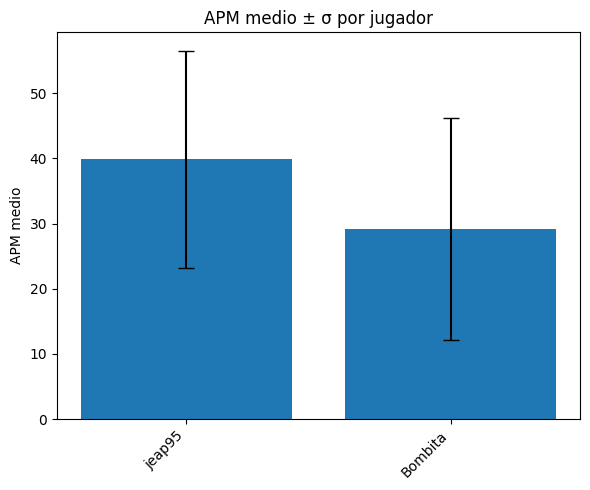


👷 Aldeanos creados:
  jeap95: 66
  Bombita: 40

⏳ Tiempo TC inactivo (s):
  jeap95: 1083.4
  Bombita: 863.2

🏗️ Unidades creadas totales y por categoría (civil/militar):
  jeap95: total=105, civil=72, militar=33
  Bombita: total=57, civil=49, militar=8

⚔️ Unidades matadas / perdidas:
  jeap95: matadas=0, perdidas=0
  Bombita: matadas=0, perdidas=0

💰 Recursos recolectados:
  jeap95: food=0, wood=0, gold=0, stone=0
  Bombita: food=0, wood=0, gold=0, stone=0

🗺️ Dibujando posición inicial de cada jugador:


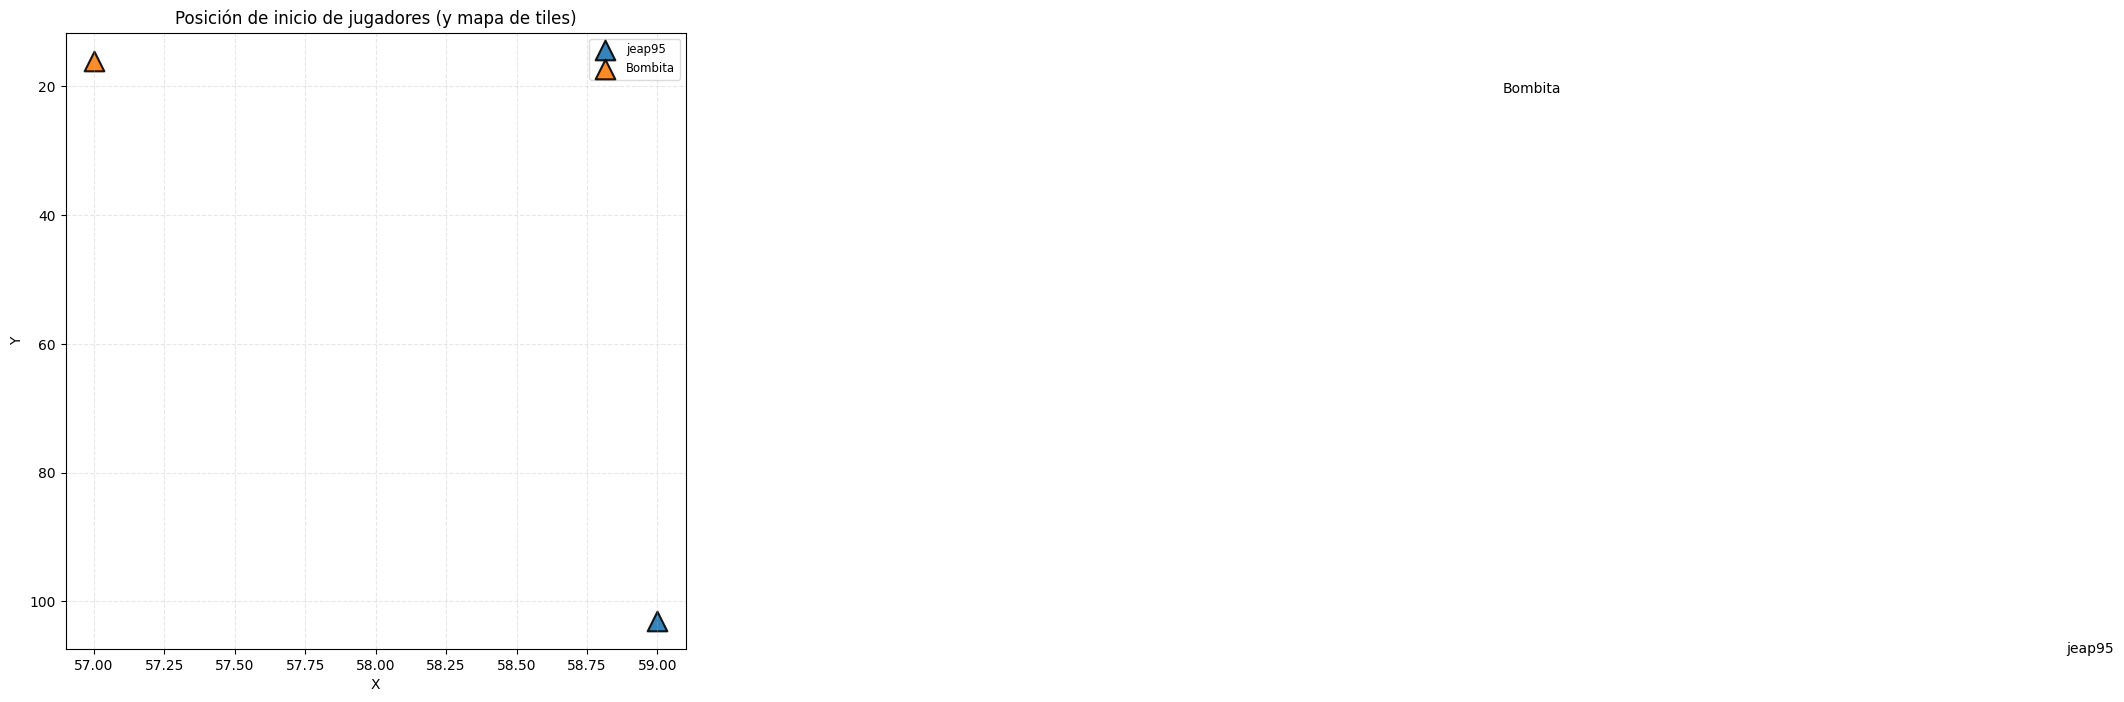


✅ ¡Análisis completado!


In [ ]:

# ==========================================
# AoE2 DE Replay Analyzer – Código Corregido
# ==========================================
# Este script está listo para copiar y pegar en Google Colab (o en un entorno local
# donde ya tengas instalados los paquetes mgz, pandas, numpy, matplotlib, tqdm).
#
# Asegúrate de haber instalado antes:
# !pip -q install --upgrade pip wheel
# !pip -q install mgz pandas numpy matplotlib tqdm
#
# El script extrae:
#  - APM (Acciones por minuto) por jugador
#  - Cantidad de aldeanos creados (filtrando la acción DE_QUEUE)
#  - Tiempo inactivo de Centro Urbano (TC) basado en lapsos entre producción de aldeanos
#  - Unidades creadas totales + civil vs militar (filtrando DE_QUEUE)
#  - Unidades matadas y perdidas (filtrando acciones KILL si existen)
#  - Recursos recolectados (filtrando GATHER_POINT)
#  - Posición de spawn de cada jugador en el mapa
#
# ==========================================

# %% ================= IMPORTS Y CONFIGURACIÓN
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mgz.model import parse_match

WINDOW_SEC = 60  # ventana de 60 segundos para cálculo de APM

# Regex para reconocer "aldeano" en inglés o español
_VILLAGER_RE = re.compile(r"(villager|aldean|aldeano)", re.IGNORECASE)


# %% ================= FUNCIONES AUXILIARES

def is_villager(unit_name: str | None) -> bool:
    """Retorna True si unit_name coincide con 'villager' o 'aldeano'."""
    if not unit_name:
        return False
    return bool(_VILLAGER_RE.search(unit_name))


def load_match(replay_path: str):
    """Carga un archivo .aoe2record y devuelve el objeto Match de mgz."""
    with open(replay_path, "rb") as fh:
        return parse_match(fh)


# %% ================= CÁLCULO DE MÉTRICAS

def villager_counts(match):
    """
    Cuenta cuántos aldeanos produjo cada jugador:
    - Filtra por acción DE_QUEUE (que en Age2DE equivale a TRAIN).
    - Extrae unit_id y luego el nombre real desde match.units[unit_id].name.
    """
    counts = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        unit_id = act.payload.get("unit_id")
        if not isinstance(unit_id, int):
            continue
        try:
            unit_name = match.units[unit_id].name
        except Exception:
            unit_name = act.payload.get("unit")  # fallback
        if is_villager(unit_name):
            pid = act.player.number if act.player else None
            if pid is not None:
                counts[pid] += 1
    return counts


def tc_idle_time(match, base_prod_time: float = 25.0, gap_threshold: float = 27.0):
    """
    Calcula el tiempo total que cada jugador dejó ocioso su TC:
    - Filtra también por DE_QUEUE para detectar producción de aldeanos.
    - Si el gap entre dos DE_QUEUE de aldeano excede gap_threshold, se suma (gap - base_prod_time).
    """
    idle = {p.number: 0.0 for p in match.players}
    last_train = {p.number: None for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        unit_id = act.payload.get("unit_id")
        if not isinstance(unit_id, int):
            continue
        try:
            name = match.units[unit_id].name
        except Exception:
            name = act.payload.get("unit")
        if not is_villager(name):
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        t = act.timestamp.total_seconds()
        if last_train[pid] is not None:
            gap = t - last_train[pid]
            if gap > gap_threshold:
                idle[pid] += gap - base_prod_time
        last_train[pid] = t
    return idle


def compute_apm_timeseries(match, window_sec: int = WINDOW_SEC):
    """
    Construye un DataFrame de APM (acciones/minuto) por jugador,
    usando ventanas de `window_sec` segundos.
    """
    rows = [
        (act.timestamp.total_seconds(), act.player.number)
        for act in match.actions
        if act.player
    ]
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows, columns=["t", "player"])
    max_t = df["t"].max()
    bins = np.arange(0, max_t + window_sec, window_sec)
    apm = {}
    for pid in df["player"].unique():
        counts, _ = np.histogram(df.loc[df["player"] == pid, "t"], bins=bins)
        apm[pid] = counts * 60 / window_sec
    ts = pd.DataFrame(apm, index=bins[:-1])
    ts.index.name = "time_sec"
    return ts


def total_units_created(match):
    """
    Cuenta el total de unidades creadas por jugador:
    - Filtra por DE_QUEUE (produce cualquier unidad, no sólo aldeano).
    """
    counts = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        pid = act.player.number if act.player else None
        if pid is not None:
            counts[pid] += 1
    return counts


def units_created_by_category(match):
    """
    Divide las unidades creadas en 'civil' vs 'militar':
    - Civil: si unit_name coincide con patrones de aldeano, barco de pesca o explorador.
    - Militar: resto de unidades.
    """
    categories = {p.number: {"civil": 0, "militar": 0} for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        unit_id = act.payload.get("unit_id")
        if not isinstance(unit_id, int):
            continue
        try:
            name = match.units[unit_id].name
        except Exception:
            name = act.payload.get("unit") or ""
        name_lower = name.lower() if name else ""
        # Heurística básica para civil
        if (
            is_villager(name)
            or "galley" in name_lower
            or "scout" in name_lower
            or "fishing" in name_lower
        ):
            categories[pid]["civil"] += 1
        else:
            categories[pid]["militar"] += 1
    return categories


def units_killed_and_lost(match):
    """
    Cuenta unidades matadas y perdidas por jugador:
    - Filtra por acción KILL (si existe).
    - payload.get("victim") da el unit_id de la víctima; se busca match.units[victim_id].owner.
    """
    kills = {p.number: 0 for p in match.players}
    lost = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name != "KILL":
            continue
        pid_killer = act.player.number if act.player else None
        victim_id = act.payload.get("victim") or act.payload.get("victim_id")
        if pid_killer is not None:
            kills[pid_killer] += 1
        if isinstance(victim_id, int):
            try:
                owner = match.units[victim_id].owner
                if owner is not None:
                    lost[owner.number] += 1
            except Exception:
                pass
    return kills, lost


def resources_from_actions(match):
    """
    Suma recursos recolectados por cada jugador:
    - Filtra por GATHER_POINT (acción que agrupa recolección de recurso).
    - payload["amount"] y payload["resource_type"] contienen cantidad y tipo.
    """
    res = {p.number: {"food": 0, "wood": 0, "gold": 0, "stone": 0} for p in match.players}
    for act in match.actions:
        if act.type.name != "GATHER_POINT":
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        amount = act.payload.get("amount") or 0
        rtype = act.payload.get("resource_type") or ""
        low = rtype.lower()
        if low in ("food", "alim", "alimento", "alimentos"):
            res[pid]["food"] += amount
        elif low in ("wood", "madera"):
            res[pid]["wood"] += amount
        elif low in ("gold", "oro"):
            res[pid]["gold"] += amount
        elif low in ("stone", "piedra"):
            res[pid]["stone"] += amount
    return res


# %% ================= FUNCIONES DE GRAFICACIÓN

def plot_apm(ts, match):
    """Grafica la curva de APM en el tiempo para cada jugador."""
    if ts.empty:
        print("Sin datos suficientes para APM.")
        return
    plt.figure(figsize=(10, 6))
    for pid in ts.columns:
        nombre = next((p.name for p in match.players if p.number == pid), str(pid))
        plt.plot(ts.index / 60, ts[pid], label=nombre)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("APM")
    plt.title(f"APM por jugador – ventana {WINDOW_SEC} s")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_apm_bar(ts, match):
    """Grafica barras del APM medio ± desviación estándar por jugador."""
    if ts.empty:
        print("Sin datos para gráfico de APM.")
        return
    means = ts.mean()
    stds = ts.std()
    nombres = [next((p.name for p in match.players if p.number == pid), str(pid)) for pid in means.index]
    x = np.arange(len(nombres))
    plt.figure(figsize=(6, 5))
    plt.bar(x, means.values, yerr=stds.values, capsize=6)
    plt.xticks(x, nombres, rotation=45, ha="right")
    plt.ylabel("APM medio")
    plt.title("APM medio ± σ por jugador")
    plt.tight_layout()
    plt.show()


def plot_map_overview(match, figsize=(8, 8)):
    """
    Dibuja la posición inicial de los jugadores en el mapa:
    - Usa p.position.x y p.position.y para cada jugador (spawn).
    - Dibuja un fondo semitransparente con match.map.tiles (escala de grises) si está disponible.
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    # Intentar dibujar mapa de tiles en fondo
    try:
        tiles = match.map.tiles
        w, h = match.map.dimension
        if isinstance(tiles, (list, tuple)):
            arr = np.array(tiles).reshape((h, w))
        else:
            arr = np.array(tiles)
        ax.imshow(arr, cmap="gray_r", alpha=0.25)
    except Exception:
        pass

    # Dibujar spawn de cada jugador usando position.x, position.y
    for p in match.players:
        pid = p.number
        nombre = p.name
        pos = p.position
        x0, y0 = pos.x, pos.y
        ax.scatter(x0, y0, marker="^", s=200, edgecolors="k", linewidths=1.5,
                   label=nombre, alpha=0.9)
        ax.text(x0 + 5, y0 + 5, nombre, fontsize=10, color="black")

    ax.set_title("Posición de inicio de jugadores (y mapa de tiles)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.invert_yaxis()
    ax.legend(loc="upper right", fontsize="small", framealpha=0.7)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()


# %% ================= SCRIPT PRINCIPAL

if __name__ == "__main__":
    from google.colab import files  # type: ignore

    print("🔄 Selecciona un archivo .aoe2record para analizar…")
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError("No se subió ningún archivo")
    REPLAY_PATH = next(iter(uploaded))

    # Cargar la partida
    match = load_match(REPLAY_PATH)
    print(f"Mapa: {match.map.name} — Duración: {match.duration.total_seconds()/60:.1f} min\n")

    # 1) APM
    print("▶︎ Calculando APM…")
    aps_ts = compute_apm_timeseries(match)
    plot_apm(aps_ts, match)
    plot_apm_bar(aps_ts, match)

    # 2) Aldeanos creados
    villagers = villager_counts(match)
    print("\n👷 Aldeanos creados:")
    for p in match.players:
        print(f"  {p.name}: {villagers.get(p.number, 0)}")

    # 3) Tiempo de TC inactivo
    idles = tc_idle_time(match)
    print("\n⏳ Tiempo TC inactivo (s):")
    for p in match.players:
        print(f"  {p.name}: {idles.get(p.number, 0):.1f}")

    # 4) Unidades creadas totales y por categoría
    total_created = total_units_created(match)
    by_cat = units_created_by_category(match)
    print("\n🏗️ Unidades creadas totales y por categoría (civil/militar):")
    for p in match.players:
        tc = total_created.get(p.number, 0)
        c = by_cat.get(p.number, {"civil": 0, "militar": 0})
        print(f"  {p.name}: total={tc}, civil={c['civil']}, militar={c['militar']}")

    # 5) Unidades matadas/perdidas
    kills, lost = units_killed_and_lost(match)
    print("\n⚔️ Unidades matadas / perdidas:")
    for p in match.players:
        print(f"  {p.name}: matadas={kills.get(p.number, 0)}, perdidas={lost.get(p.number, 0)}")

    # 6) Recursos recolectados
    res = resources_from_actions(match)
    print("\n💰 Recursos recolectados:")
    for p in match.players:
        r = res.get(p.number, {})
        print(f"  {p.name}: food={r.get('food', 0)}, wood={r.get('wood', 0)}, gold={r.get('gold', 0)}, stone={r.get('stone', 0)}")

    # 7) Posición inicial de jugadores en el mapa
    print("\n🗺️ Dibujando posición inicial de cada jugador:")
    plot_map_overview(match)

    print("\n✅ ¡Análisis completado!")



🔄 Selecciona un archivo .aoe2record para analizar…


Saving AgeIIDE_Replay_398140917.aoe2record to AgeIIDE_Replay_398140917 (3).aoe2record
Mapa: Arabia — Duración: 31.5 min

▶︎ Calculando APM…


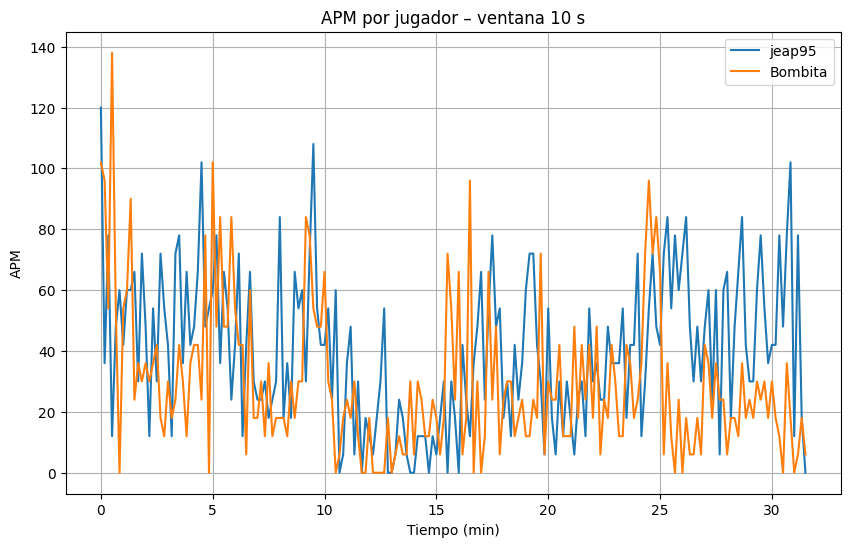

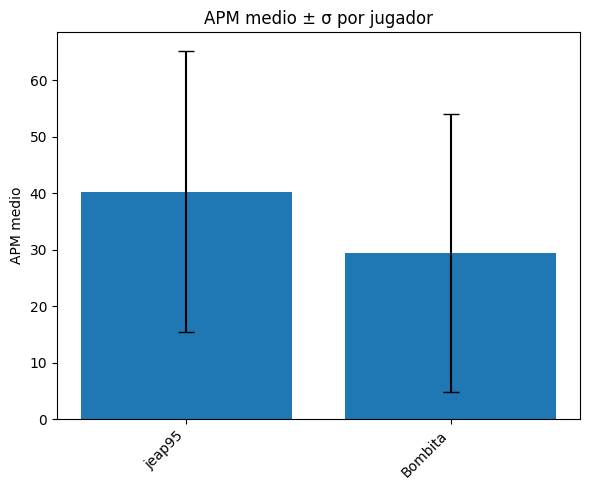


👷 Aldeanos creados:
  jeap95: 66
  Bombita: 40

⏳ Tiempo TC inactivo (s):
  jeap95: 1083.4
  Bombita: 863.2

🏗️ Unidades creadas totales y por categoría (civil/militar):
  jeap95: total=105, civil=72, militar=33
  Bombita: total=57, civil=49, militar=8

⚔️ Unidades matadas / perdidas:
  jeap95: matadas=0, perdidas=0
  Bombita: matadas=0, perdidas=0

💰 Recursos recolectados:
  jeap95: food=0, wood=0, gold=0, stone=0
  Bombita: food=0, wood=0, gold=0, stone=0

🗺️ Dibujando posición inicial de cada jugador:


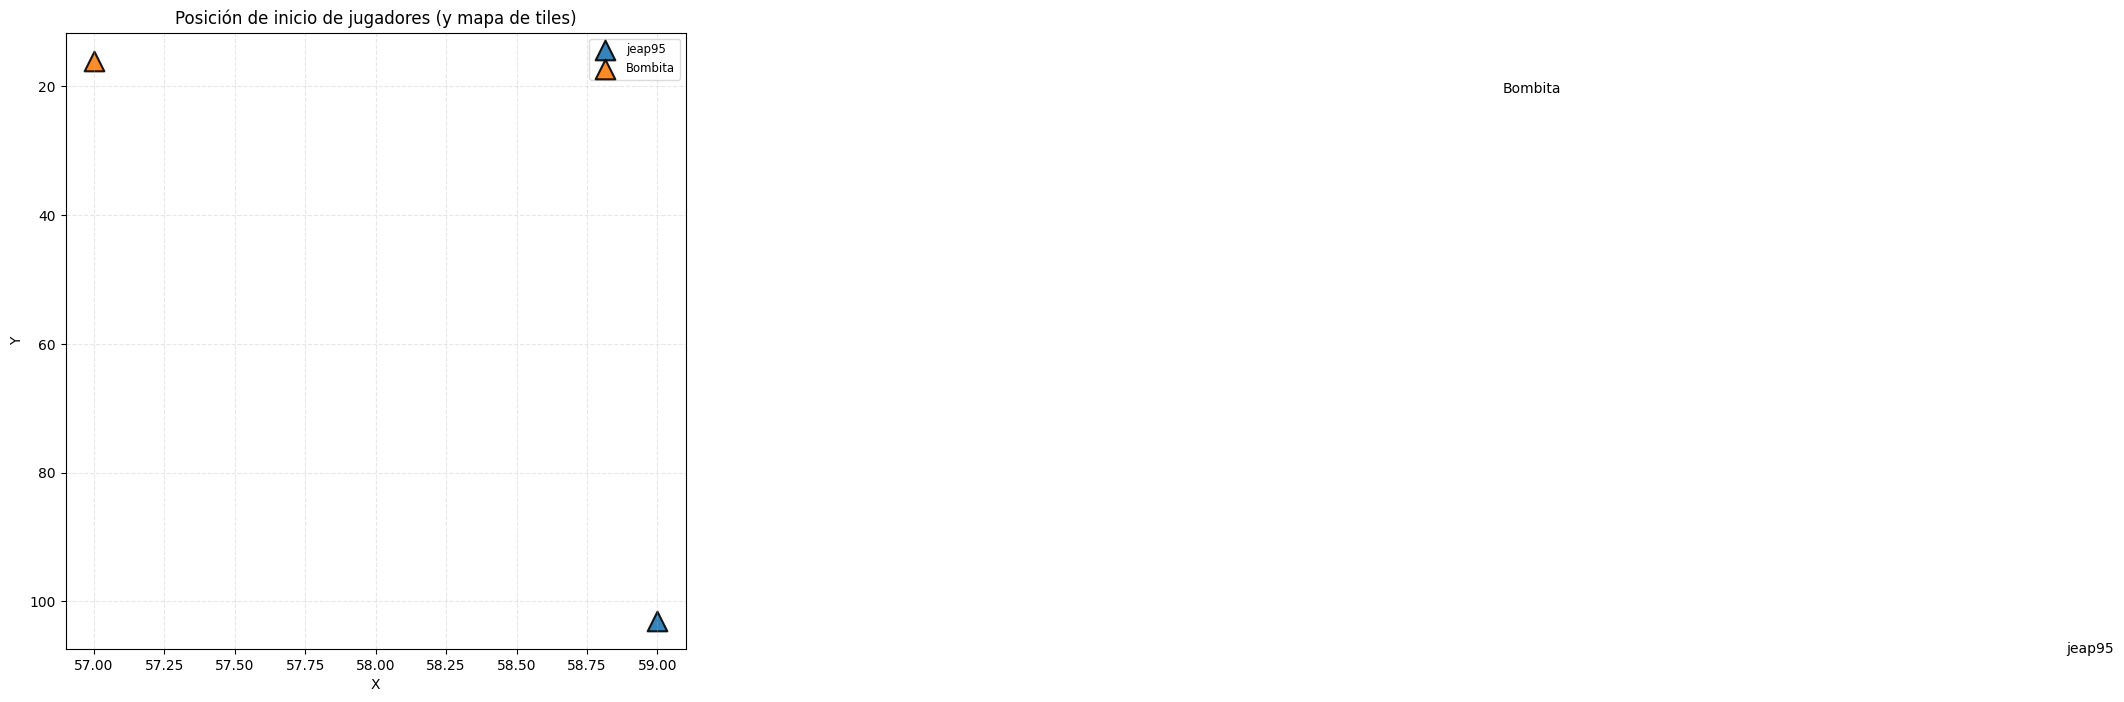


✅ ¡Análisis completado!


In [ ]:

# ==========================================
# AoE2 DE Replay Analyzer – Código Corregido
# ==========================================
# Este script está listo para copiar y pegar en Google Colab (o en un entorno local
# donde ya tengas instalados los paquetes mgz, pandas, numpy, matplotlib, tqdm).
#
# Asegúrate de haber instalado antes:
# !pip -q install --upgrade pip wheel
# !pip -q install mgz pandas numpy matplotlib tqdm
#
# El script extrae:
#  - APM (Acciones por minuto) por jugador
#  - Cantidad de aldeanos creados (filtrando la acción DE_QUEUE)
#  - Tiempo inactivo de Centro Urbano (TC) basado en lapsos entre producción de aldeanos
#  - Unidades creadas totales + civil vs militar (filtrando DE_QUEUE)
#  - Unidades matadas y perdidas (filtrando acciones KILL si existen)
#  - Recursos recolectados (filtrando GATHER_POINT)
#  - Posición de spawn de cada jugador en el mapa
#
# ==========================================

# %% ================= IMPORTS Y CONFIGURACIÓN
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mgz.model import parse_match

WINDOW_SEC = 10  # ventana de 60 segundos para cálculo de APM

# Regex para reconocer "aldeano" en inglés o español
_VILLAGER_RE = re.compile(r"(villager|aldean|aldeano)", re.IGNORECASE)


# %% ================= FUNCIONES AUXILIARES

def is_villager(unit_name: str | None) -> bool:
    """Retorna True si unit_name coincide con 'villager' o 'aldeano'."""
    if not unit_name:
        return False
    return bool(_VILLAGER_RE.search(unit_name))


def load_match(replay_path: str):
    """Carga un archivo .aoe2record y devuelve el objeto Match de mgz."""
    with open(replay_path, "rb") as fh:
        return parse_match(fh)


# %% ================= CÁLCULO DE MÉTRICAS

def villager_counts(match):
    """
    Cuenta cuántos aldeanos produjo cada jugador:
    - Filtra por acción DE_QUEUE (que en Age2DE equivale a TRAIN).
    - Extrae unit_id y luego el nombre real desde match.units[unit_id].name.
    """
    counts = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        unit_id = act.payload.get("unit_id")
        if not isinstance(unit_id, int):
            continue
        try:
            unit_name = match.units[unit_id].name
        except Exception:
            unit_name = act.payload.get("unit")  # fallback
        if is_villager(unit_name):
            pid = act.player.number if act.player else None
            if pid is not None:
                counts[pid] += 1
    return counts


def tc_idle_time(match, base_prod_time: float = 25.0, gap_threshold: float = 27.0):
    """
    Calcula el tiempo total que cada jugador dejó ocioso su TC:
    - Filtra también por DE_QUEUE para detectar producción de aldeanos.
    - Si el gap entre dos DE_QUEUE de aldeano excede gap_threshold, se suma (gap - base_prod_time).
    """
    idle = {p.number: 0.0 for p in match.players}
    last_train = {p.number: None for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        unit_id = act.payload.get("unit_id")
        if not isinstance(unit_id, int):
            continue
        try:
            name = match.units[unit_id].name
        except Exception:
            name = act.payload.get("unit")
        if not is_villager(name):
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        t = act.timestamp.total_seconds()
        if last_train[pid] is not None:
            gap = t - last_train[pid]
            if gap > gap_threshold:
                idle[pid] += gap - base_prod_time
        last_train[pid] = t
    return idle


def compute_apm_timeseries(match, window_sec: int = WINDOW_SEC):
    """
    Construye un DataFrame de APM (acciones/minuto) por jugador,
    usando ventanas de `window_sec` segundos.
    """
    rows = [
        (act.timestamp.total_seconds(), act.player.number)
        for act in match.actions
        if act.player
    ]
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows, columns=["t", "player"])
    max_t = df["t"].max()
    bins = np.arange(0, max_t + window_sec, window_sec)
    apm = {}
    for pid in df["player"].unique():
        counts, _ = np.histogram(df.loc[df["player"] == pid, "t"], bins=bins)
        apm[pid] = counts * 60 / window_sec
    ts = pd.DataFrame(apm, index=bins[:-1])
    ts.index.name = "time_sec"
    return ts


def total_units_created(match):
    """
    Cuenta el total de unidades creadas por jugador:
    - Filtra por DE_QUEUE (produce cualquier unidad, no sólo aldeano).
    """
    counts = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        pid = act.player.number if act.player else None
        if pid is not None:
            counts[pid] += 1
    return counts


def units_created_by_category(match):
    """
    Divide las unidades creadas en 'civil' vs 'militar':
    - Civil: si unit_name coincide con patrones de aldeano, barco de pesca o explorador.
    - Militar: resto de unidades.
    """
    categories = {p.number: {"civil": 0, "militar": 0} for p in match.players}
    for act in match.actions:
        if act.type.name != "DE_QUEUE":
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        unit_id = act.payload.get("unit_id")
        if not isinstance(unit_id, int):
            continue
        try:
            name = match.units[unit_id].name
        except Exception:
            name = act.payload.get("unit") or ""
        name_lower = name.lower() if name else ""
        # Heurística básica para civil
        if (
            is_villager(name)
            or "galley" in name_lower
            or "scout" in name_lower
            or "fishing" in name_lower
        ):
            categories[pid]["civil"] += 1
        else:
            categories[pid]["militar"] += 1
    return categories


def units_killed_and_lost(match):
    """
    Cuenta unidades matadas y perdidas por jugador:
    - Filtra por acción KILL (si existe).
    - payload.get("victim") da el unit_id de la víctima; se busca match.units[victim_id].owner.
    """
    kills = {p.number: 0 for p in match.players}
    lost = {p.number: 0 for p in match.players}
    for act in match.actions:
        if act.type.name != "KILL":
            continue
        pid_killer = act.player.number if act.player else None
        victim_id = act.payload.get("victim") or act.payload.get("victim_id")
        if pid_killer is not None:
            kills[pid_killer] += 1
        if isinstance(victim_id, int):
            try:
                owner = match.units[victim_id].owner
                if owner is not None:
                    lost[owner.number] += 1
            except Exception:
                pass
    return kills, lost


def resources_from_actions(match):
    """
    Suma recursos recolectados por cada jugador:
    - Filtra por GATHER_POINT (acción que agrupa recolección de recurso).
    - payload["amount"] y payload["resource_type"] contienen cantidad y tipo.
    """
    res = {p.number: {"food": 0, "wood": 0, "gold": 0, "stone": 0} for p in match.players}
    for act in match.actions:
        if act.type.name != "GATHER_POINT":
            continue
        pid = act.player.number if act.player else None
        if pid is None:
            continue
        amount = act.payload.get("amount") or 0
        rtype = act.payload.get("resource_type") or ""
        low = rtype.lower()
        if low in ("food", "alim", "alimento", "alimentos"):
            res[pid]["food"] += amount
        elif low in ("wood", "madera"):
            res[pid]["wood"] += amount
        elif low in ("gold", "oro"):
            res[pid]["gold"] += amount
        elif low in ("stone", "piedra"):
            res[pid]["stone"] += amount
    return res


# %% ================= FUNCIONES DE GRAFICACIÓN

def plot_apm(ts, match):
    """Grafica la curva de APM en el tiempo para cada jugador."""
    if ts.empty:
        print("Sin datos suficientes para APM.")
        return
    plt.figure(figsize=(10, 6))
    for pid in ts.columns:
        nombre = next((p.name for p in match.players if p.number == pid), str(pid))
        plt.plot(ts.index / 60, ts[pid], label=nombre)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("APM")
    plt.title(f"APM por jugador – ventana {WINDOW_SEC} s")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_apm_bar(ts, match):
    """Grafica barras del APM medio ± desviación estándar por jugador."""
    if ts.empty:
        print("Sin datos para gráfico de APM.")
        return
    means = ts.mean()
    stds = ts.std()
    nombres = [next((p.name for p in match.players if p.number == pid), str(pid)) for pid in means.index]
    x = np.arange(len(nombres))
    plt.figure(figsize=(6, 5))
    plt.bar(x, means.values, yerr=stds.values, capsize=6)
    plt.xticks(x, nombres, rotation=45, ha="right")
    plt.ylabel("APM medio")
    plt.title("APM medio ± σ por jugador")
    plt.tight_layout()
    plt.show()


def plot_map_overview(match, figsize=(8, 8)):
    """
    Dibuja la posición inicial de los jugadores en el mapa:
    - Usa p.position.x y p.position.y para cada jugador (spawn).
    - Dibuja un fondo semitransparente con match.map.tiles (escala de grises) si está disponible.
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    # Intentar dibujar mapa de tiles en fondo
    try:
        tiles = match.map.tiles
        w, h = match.map.dimension
        if isinstance(tiles, (list, tuple)):
            arr = np.array(tiles).reshape((h, w))
        else:
            arr = np.array(tiles)
        ax.imshow(arr, cmap="gray_r", alpha=0.25)
    except Exception:
        pass

    # Dibujar spawn de cada jugador usando position.x, position.y
    for p in match.players:
        pid = p.number
        nombre = p.name
        pos = p.position
        x0, y0 = pos.x, pos.y
        ax.scatter(x0, y0, marker="^", s=200, edgecolors="k", linewidths=1.5,
                   label=nombre, alpha=0.9)
        ax.text(x0 + 5, y0 + 5, nombre, fontsize=10, color="black")

    ax.set_title("Posición de inicio de jugadores (y mapa de tiles)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.invert_yaxis()
    ax.legend(loc="upper right", fontsize="small", framealpha=0.7)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()


# %% ================= SCRIPT PRINCIPAL

if __name__ == "__main__":
    from google.colab import files  # type: ignore

    print("🔄 Selecciona un archivo .aoe2record para analizar…")
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError("No se subió ningún archivo")
    REPLAY_PATH = next(iter(uploaded))

    # Cargar la partida
    match = load_match(REPLAY_PATH)
    print(f"Mapa: {match.map.name} — Duración: {match.duration.total_seconds()/60:.1f} min\n")

    # 1) APM
    print("▶︎ Calculando APM…")
    aps_ts = compute_apm_timeseries(match)
    plot_apm(aps_ts, match)
    plot_apm_bar(aps_ts, match)

    # 2) Aldeanos creados
    villagers = villager_counts(match)
    print("\n👷 Aldeanos creados:")
    for p in match.players:
        print(f"  {p.name}: {villagers.get(p.number, 0)}")

    # 3) Tiempo de TC inactivo
    idles = tc_idle_time(match)
    print("\n⏳ Tiempo TC inactivo (s):")
    for p in match.players:
        print(f"  {p.name}: {idles.get(p.number, 0):.1f}")

    # 4) Unidades creadas totales y por categoría
    total_created = total_units_created(match)
    by_cat = units_created_by_category(match)
    print("\n🏗️ Unidades creadas totales y por categoría (civil/militar):")
    for p in match.players:
        tc = total_created.get(p.number, 0)
        c = by_cat.get(p.number, {"civil": 0, "militar": 0})
        print(f"  {p.name}: total={tc}, civil={c['civil']}, militar={c['militar']}")

    # 5) Unidades matadas/perdidas
    kills, lost = units_killed_and_lost(match)
    print("\n⚔️ Unidades matadas / perdidas:")
    for p in match.players:
        print(f"  {p.name}: matadas={kills.get(p.number, 0)}, perdidas={lost.get(p.number, 0)}")

    # 6) Recursos recolectados
    res = resources_from_actions(match)
    print("\n💰 Recursos recolectados:")
    for p in match.players:
        r = res.get(p.number, {})
        print(f"  {p.name}: food={r.get('food', 0)}, wood={r.get('wood', 0)}, gold={r.get('gold', 0)}, stone={r.get('stone', 0)}")

    # 7) Posición inicial de jugadores en el mapa
    print("\n🗺️ Dibujando posición inicial de cada jugador:")
    plot_map_overview(match)

    print("\n✅ ¡Análisis completado!")



## Cambios hechos el 7-6-25

## Version 1.0, muestra aldeanos totales acumulados por equipo en funcion del tiempo

🔄 Selecciona un archivo .aoe2record para analizar…


Saving AgeIIDE_Replay_398140917.aoe2record to AgeIIDE_Replay_398140917 (5).aoe2record
Mapa: Arabia — Duración: 31.5 min

▶︎ Calculando APM…


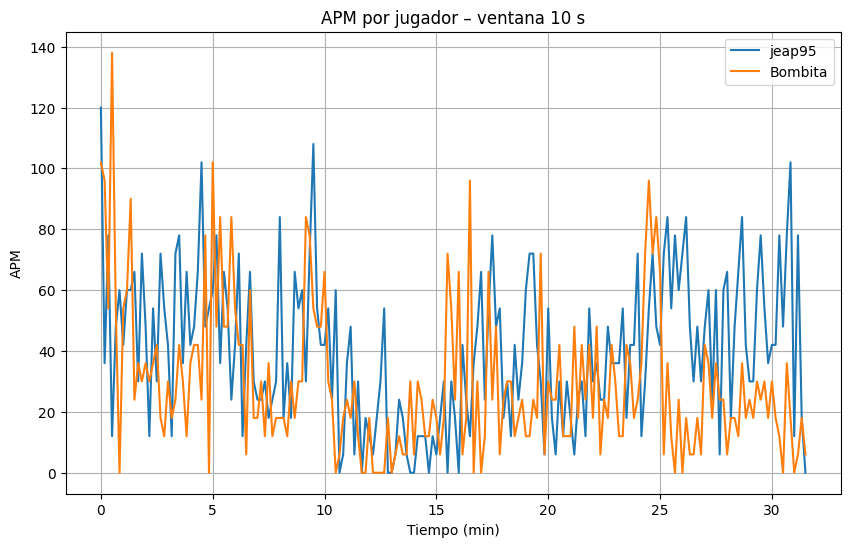

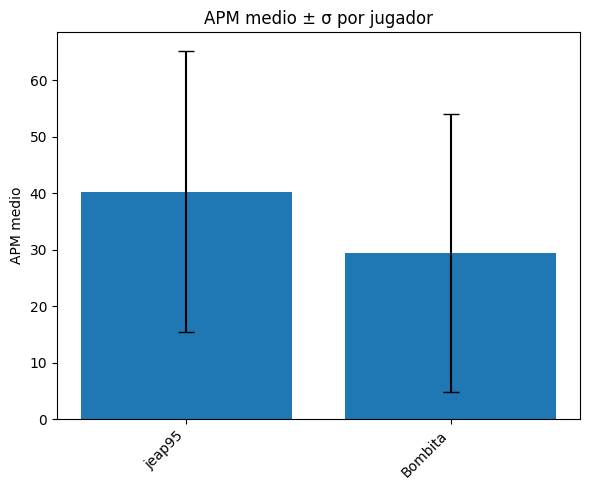


👷 Aldeanos creados:
  jeap95: 66
  Bombita: 40

⏳ Tiempo TC inactivo (s):
  jeap95: 1083.4
  Bombita: 863.2

🏠 Posición del Centro Urbano:
  jeap95: x=59.0, y=103.0
  Bombita: x=57.0, y=16.0


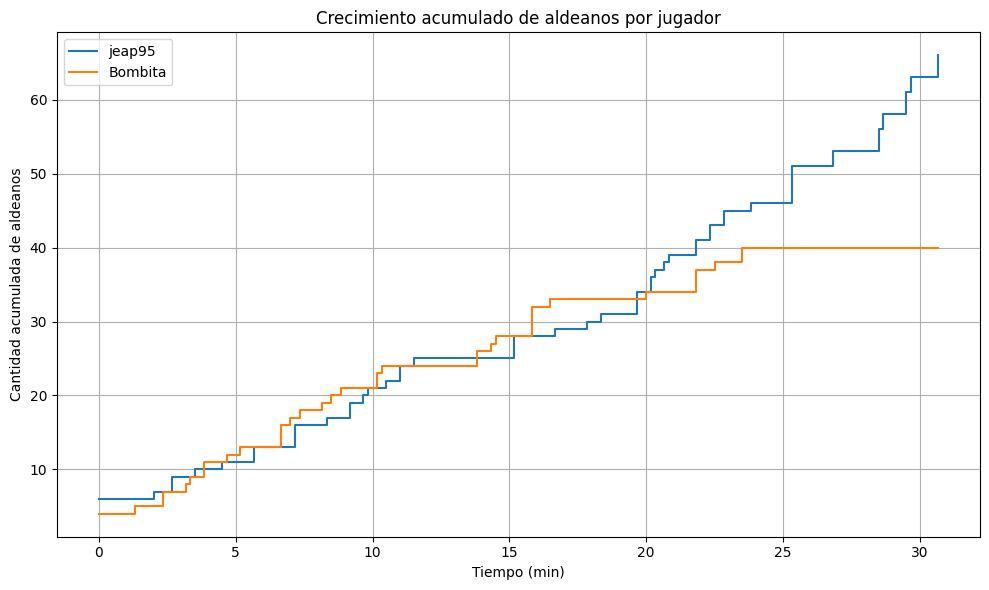

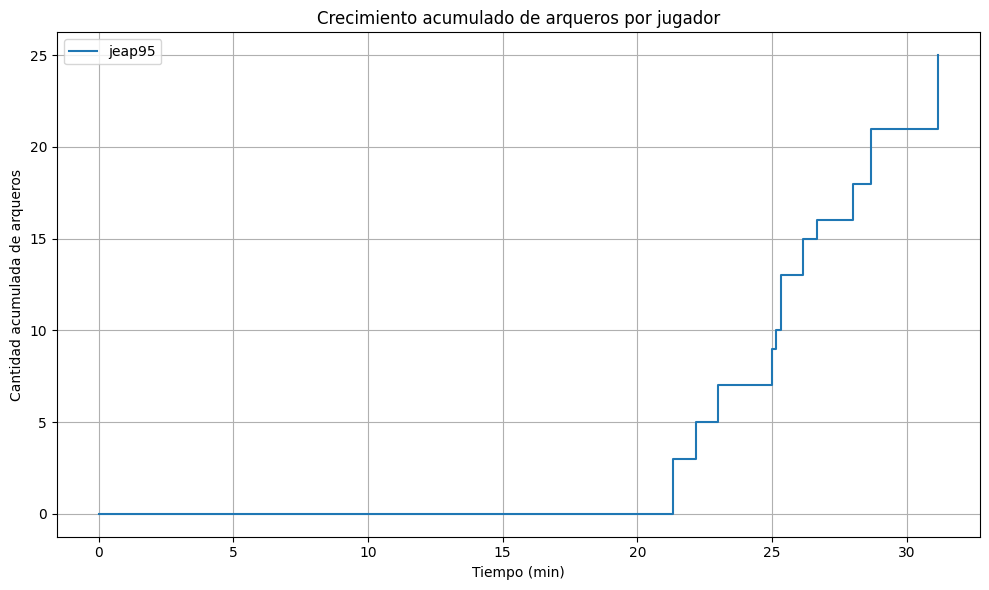


✅ ¡Análisis completado!


In [ ]:
# ==========================================
# AoE2 DE Replay Analyzer – Parser Mejorado
# ==========================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mgz.model import parse_match

WINDOW_SEC = 10  # ventana de 10 segundos para cálculo de APM y acumulados

# Regex para reconocer "aldeano", "arquero"
_VILLAGER_RE = re.compile(r"(villager|aldean|aldeano)", re.IGNORECASE)
_ARCHER_RE = re.compile(r"(archer|arquero)", re.IGNORECASE)

# ------------------------------------------
# Funciones auxiliares existentes
# ------------------------------------------

def load_match(replay_path: str):
    """Carga un archivo .aoe2record y devuelve el objeto Match de mgz."""
    with open(replay_path, "rb") as fh:
        return parse_match(fh)

# Mantener villager_counts, tc_idle_time, compute_apm_timeseries, plot_apm, plot_apm_bar, etc.
# (Asumir que estas funciones se mantienen sin cambios)

# ------------------------------------------
# Nuevas funciones solicitadas (correcciones)
# ------------------------------------------

def town_center_positions(match):
    """
    Devuelve un diccionario {player_number: (x, y)} con la posición inicial del
    Centro Urbano de cada jugador basado en match.players[i].position.
    """
    positions = {}
    for p in match.players:
        try:
            pos = p.position
            positions[p.number] = (pos.x, pos.y)
        except Exception:
            positions[p.number] = None
    return positions


def compute_cumulative_creations(match, unit_re, window_sec=WINDOW_SEC):
    """
    Construye un DataFrame con la serie acumulada de creaciones de un tipo de unidad:
    - Filtra acciones DE_QUEUE por `unit_re`.
    - Agrega en ventanas de `window_sec` segundos.
    """
    rows = []
    for act in match.actions:
        if act.type.name != "DE_QUEUE" or not act.player:
            continue
        payload = act.payload
        unit_id = payload.get("unit_id")
        if not isinstance(unit_id, int):
            continue
        # Obtener nombre de la unidad con fallback
        try:
            unit_name = match.units[unit_id].name
        except Exception:
            unit_name = payload.get("unit") or ""
        if not unit_re.search(unit_name):
            continue
        rows.append((act.timestamp.total_seconds(), act.player.number))

    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows, columns=["t", "player"])
    max_t = df["t"].max()
    bins = np.arange(0, max_t + window_sec, window_sec)
    cum = {}
    for pid in df["player"].unique():
        counts, _ = np.histogram(df[df["player"] == pid]["t"], bins=bins)
        cum[pid] = np.cumsum(counts)
    ts = pd.DataFrame(cum, index=bins[:-1])
    ts.index.name = "time_sec"
    return ts


def plot_cumulative_units(ts, match, unit_name):
    """
    Grafica la curva acumulada de unidades creadas:
    - Eje X en minutos.
    - Curvas step para cada jugador.
    """
    if ts.empty:
        print(f"Sin datos suficientes para {unit_name}.")
        return
    plt.figure(figsize=(10, 6))
    for pid in ts.columns:
        nombre = next((p.name for p in match.players if p.number == pid), str(pid))
        plt.step(ts.index / 60, ts[pid], where="post", label=nombre)
    plt.xlabel("Tiempo (min)")
    plt.ylabel(f"Cantidad acumulada de {unit_name}")
    plt.title(f"Crecimiento acumulado de {unit_name} por jugador")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------
# Script principal actualizado
# ------------------------------------------
if __name__ == "__main__":
    from google.colab import files

    print("🔄 Selecciona un archivo .aoe2record para analizar…")
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError("No se subió ningún archivo")
    REPLAY_PATH = next(iter(uploaded))

    match = load_match(REPLAY_PATH)
    print(f"Mapa: {match.map.name} — Duración: {match.duration.total_seconds()/60:.1f} min\n")

    # 1) APM
    print("▶︎ Calculando APM…")
    aps_ts = compute_apm_timeseries(match)
    plot_apm(aps_ts, match)
    plot_apm_bar(aps_ts, match)

    # 2) Aldeanos creados
    villagers = villager_counts(match)
    print("\n👷 Aldeanos creados:")
    for p in match.players:
        print(f"  {p.name}: {villagers.get(p.number, 0)}")

    # 3) Tiempo TC inactivo
    idles = tc_idle_time(match)
    print("\n⏳ Tiempo TC inactivo (s):")
    for p in match.players:
        print(f"  {p.name}: {idles.get(p.number, 0):.1f}")

    # 4) Posición del Centro Urbano
    tc_positions = town_center_positions(match)
    print("\n🏠 Posición del Centro Urbano:")
    for p in match.players:
        pos = tc_positions.get(p.number)
        if pos:
            x, y = pos
            print(f"  {p.name}: x={x}, y={y}")
        else:
            print(f"  {p.name}: No encontrado")

    # 5) Gráficos acumulativos
    villager_ts = compute_cumulative_creations(match, _VILLAGER_RE)
    plot_cumulative_units(villager_ts, match, "aldeanos")
    archer_ts = compute_cumulative_creations(match, _ARCHER_RE)
    plot_cumulative_units(archer_ts, match, "arqueros")

    print("\n✅ ¡Análisis completado!")


🔄 Selecciona un archivo .aoe2record para analizar…


Saving AgeIIDE_Replay_398140917.aoe2record to AgeIIDE_Replay_398140917 (10).aoe2record
Mapa: Arabia — Duración: 31.5 min

▶︎ Calculando APM…


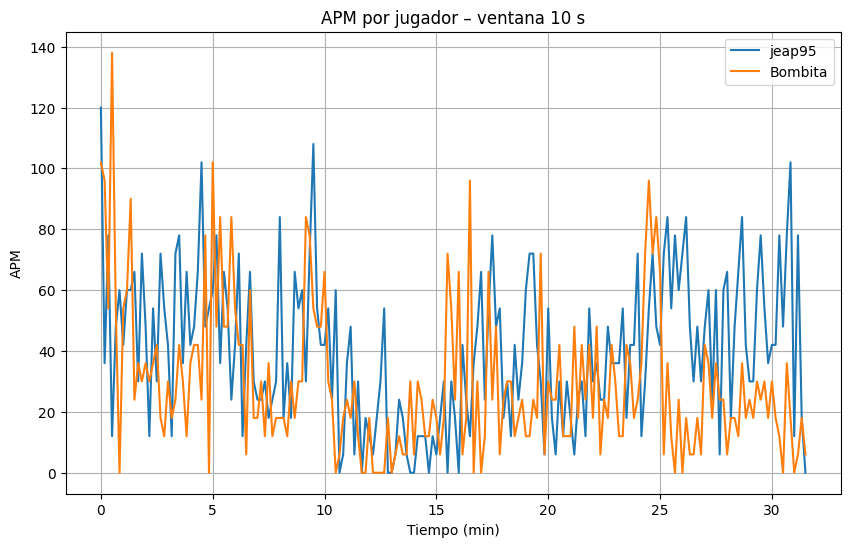

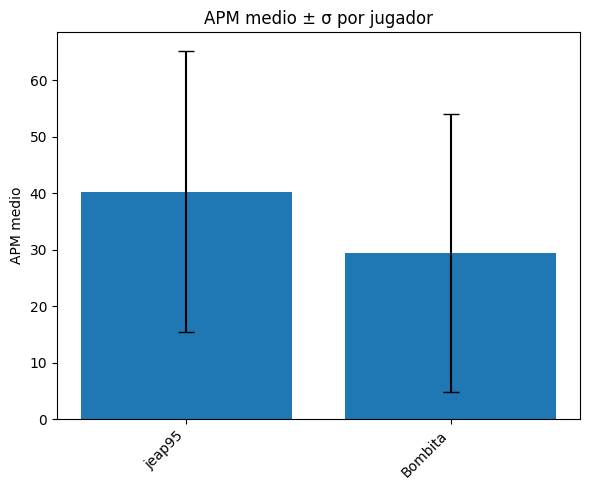


👷 Aldeanos creados:
  jeap95: 66
  Bombita: 40

⏳ Tiempo TC inactivo (s):
  jeap95: 1083.4
  Bombita: 863.2

🏠 Posición del Centro Urbano:
  jeap95: x=59.0, y=103.0
  Bombita: x=57.0, y=16.0


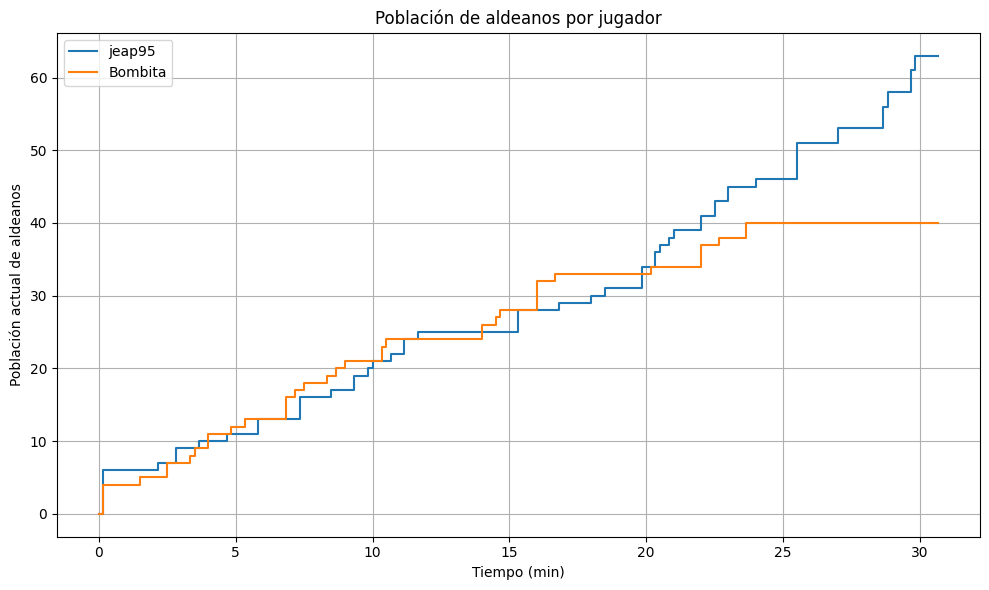

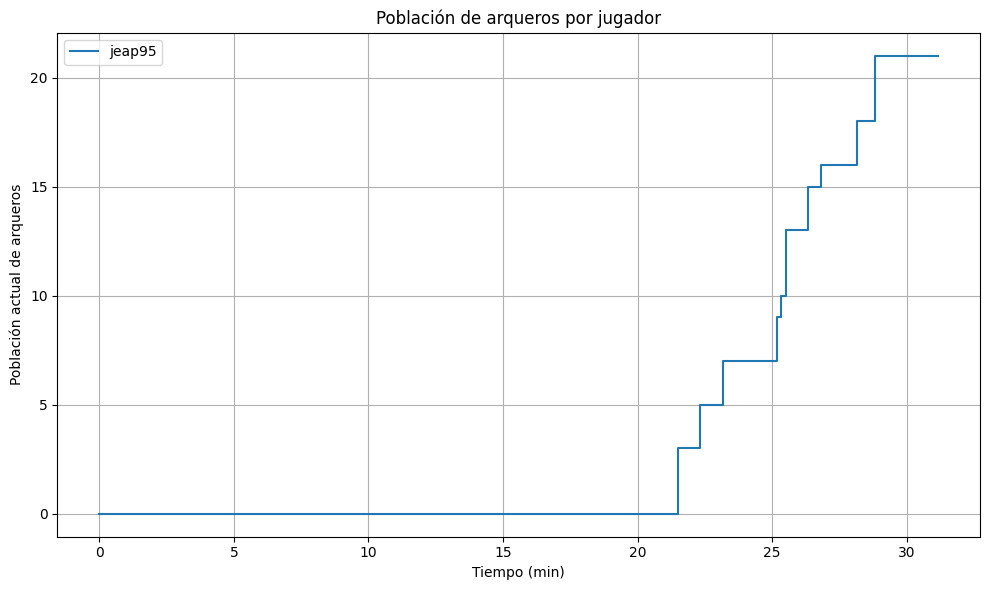


✅ ¡Análisis completado!


In [ ]:
# ==========================================
# AoE2 DE Replay Analyzer – Parser Mejorado
# ==========================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mgz.model import parse_match

WINDOW_SEC = 10  # ventana de 10 segundos para cálculo de APM y poblaciones

# Regex para reconocer "aldeano", "arquero"
_VILLAGER_RE = re.compile(r"(villager|aldean|aldeano)", re.IGNORECASE)
_ARCHER_RE = re.compile(r"(archer|arquero)", re.IGNORECASE)

# ------------------------------------------
# Funciones auxiliares existentes
# ------------------------------------------

def load_match(replay_path: str):
    """Carga un archivo .aoe2record y devuelve el objeto Match de mgz."""
    with open(replay_path, "rb") as fh:
        return parse_match(fh)

# Mantener villager_counts, tc_idle_time, compute_apm_timeseries, plot_apm, plot_apm_bar, etc.

# ------------------------------------------
# Funciones para población de unidades mejoradas
# ------------------------------------------

def compute_population_timeseries(match, unit_re, window_sec=WINDOW_SEC):
    """
    Construye un DataFrame con la serie temporal de población actual:
    - +1 por cada DE_QUEUE de unidad que coincida con `unit_re`.
    - -1 por cada muerte detectada en acciones de tipo que contengan 'KILL' o 'DIE'.
    - Re-muestrea a ventanas de `window_sec` segundos tomando la población al final de cada ventana.
    """
    events = []
    # Creaciones
    for act in match.actions:
        if act.type.name == "DE_QUEUE" and act.player:
            uid = act.payload.get("unit_id")
            if isinstance(uid, int):
                try:
                    name = match.units[uid].name
                except Exception:
                    name = act.payload.get("unit") or ""
                if unit_re.search(name):
                    events.append((act.timestamp.total_seconds(), act.player.number, 1))
    # Muertes
    for act in match.actions:
        # victim unit id
        vid = None
        if hasattr(act.payload, 'get'):
            vid = act.payload.get("victim") or act.payload.get("victim_id") or act.payload.get("unit_id")
        if isinstance(vid, int):
            try:
                unit = match.units[vid]
                owner = unit.owner
                name = unit.name
            except Exception:
                continue
            if owner and unit_re.search(name) and ("KILL" in act.type.name or "DIE" in act.type.name):
                events.append((act.timestamp.total_seconds(), owner.number, -1))
    # Si no hay eventos, devolver vacío
    df_evt = pd.DataFrame(events, columns=["t","player","delta"]) if events else pd.DataFrame()
    if df_evt.empty:
        return pd.DataFrame()
    # ordenar
    df_evt = df_evt.sort_values("t")
    max_t = df_evt["t"].max()
    # definir puntos de muestreo
    bins = np.arange(0, max_t + window_sec, window_sec)
    ts = pd.DataFrame(index=bins[:-1])
    # para cada jugador, construir serie acumulada y remuestrear
    for pid in df_evt["player"].unique():
        sub = df_evt[df_evt["player"]==pid]
        sub = sub.copy()
        sub["cum"] = sub["delta"].cumsum()
        s = pd.Series(sub["cum"].values, index=sub["t"].values)
        # reindex con ffill para ventanas
        pop = s.reindex(bins[:-1], method="ffill").fillna(0).values
        ts[pid] = pop
    ts.index.name = "time_sec"
    return ts


def plot_population(ts, match, unit_name):
    """
    Grafica la curva de población actual de unidades:
    - Eje X en minutos.
    - Curvas step para cada jugador.
    """
    if ts.empty:
        print(f"Sin datos suficientes para población de {unit_name}.")
        return
    plt.figure(figsize=(10, 6))
    for pid in ts.columns:
        nombre = next((p.name for p in match.players if p.number == pid), str(pid))
        plt.step(ts.index / 60, ts[pid], where="post", label=nombre)
    plt.xlabel("Tiempo (min)")
    plt.ylabel(f"Población actual de {unit_name}")
    plt.title(f"Población de {unit_name} por jugador")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------
# Script principal
# ------------------------------------------
if __name__ == "__main__":
    from google.colab import files

    print("🔄 Selecciona un archivo .aoe2record para analizar…")
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError("No se subió ningún archivo")
    REPLAY_PATH = next(iter(uploaded))

    match = load_match(REPLAY_PATH)
    print(f"Mapa: {match.map.name} — Duración: {match.duration.total_seconds()/60:.1f} min\n")

    # 1) APM
    print("▶︎ Calculando APM…")
    aps_ts = compute_apm_timeseries(match)
    plot_apm(aps_ts, match)
    plot_apm_bar(aps_ts, match)

    # 2) Aldeanos creados
    villagers = villager_counts(match)
    print("\n👷 Aldeanos creados:")
    for p in match.players:
        print(f"  {p.name}: {villagers.get(p.number, 0)}")

    # 3) Tiempo TC inactivo
    idles = tc_idle_time(match)
    print("\n⏳ Tiempo TC inactivo (s):")
    for p in match.players:
        print(f"  {p.name}: {idles.get(p.number, 0):.1f}")

    # 4) Posición del Centro Urbano
    tc_positions = town_center_positions(match)
    print("\n🏠 Posición del Centro Urbano:")
    for p in match.players:
        pos = tc_positions.get(p.number)
        if pos:
            x, y = pos
            print(f"  {p.name}: x={x}, y={y}")
        else:
            print(f"  {p.name}: No encontrado")

    # 5) Gráficos de población actual
    villager_pop = compute_population_timeseries(match, _VILLAGER_RE)
    plot_population(villager_pop, match, "aldeanos")
    archer_pop = compute_population_timeseries(match, _ARCHER_RE)
    plot_population(archer_pop, match, "arqueros")

    print("\n✅ ¡Análisis completado!")


In [ ]:
import subprocess, sys
import json

# 1) Asegurarnos de tener mgz disponible
try:
    from mgz.model import parse_match
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mgz"])
    from mgz.model import parse_match

# 2) Parsear el replay
replay_path = "AgeIIDE_Replay_398140917.aoe2record"
with open(replay_path, "rb") as f:
    match = parse_match(f)

# 3) Construir el dict sin match.units
match_dict = {
    "map": match.map.name,
    "duration": match.duration.total_seconds(),
    "players": [
        {
            "number": p.number,
            "name": p.name,
            "position": {"x": p.position.x, "y": p.position.y},
        }
        for p in match.players
    ],
    "actions": [
        {
            "time": act.timestamp.total_seconds(),
            "player": act.player.number if act.player else None,
            "type": act.type.name,
            # simplemente vuelco todo el payload tal cual lo entrega mgz
            "payload": act.payload,
        }
        for act in match.actions
    ],
}

# 4) Guardar a JSON
with open("match.json", "w") as f:
    json.dump(match_dict, f, indent=2)

print("✅ match.json generado. Súbelo aquí para que lo carguemos como JSON.")


✅ match.json generado. Súbelo aquí para que lo carguemos como JSON.
